# Machine Learnig with Amazon Planet Dataset (Google Colab)

## Import libraries and Downloading data

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
## upload kaggle.json file

from google.colab import files

uploaded = files.upload()

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

100% 598M/600M [00:12<00:00, 43.0MB/s]
100% 600M/600M [00:12<00:00, 49.1MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 47.9MB/s]


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/planet/train-jpg'),
 PosixPath('/root/.fastai/data/planet/train-jpg.tar.7z'),
 PosixPath('/root/.fastai/data/planet/train_v2.csv'),
 PosixPath('/root/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/root/.fastai/data/planet/__MACOSX')]

## Multiclassification, pre-process data

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(2)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
                            .split_by_rand_pct(0.2)
                            .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128).databunch().normalize(imagenet_stats))

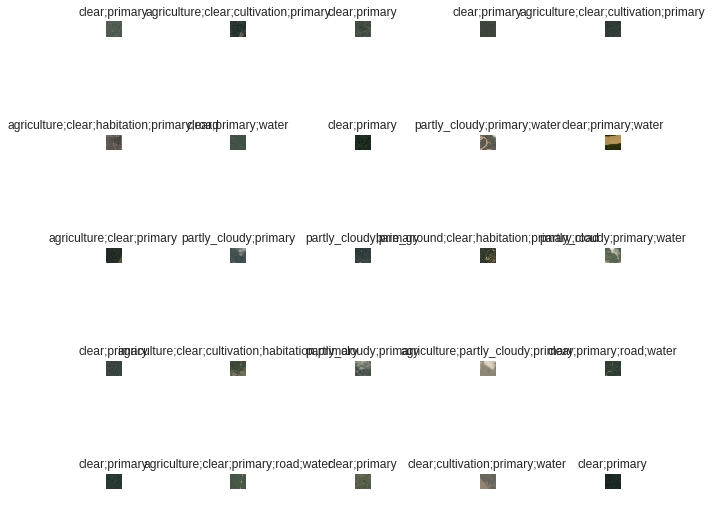

In [0]:
data.show_batch(row=3, figsize=(9,8))

In [0]:
## select the arch
arch = models.resnet34

In [0]:
## evaluation metrics

acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 92184731.42it/s]


In [0]:
## finding learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


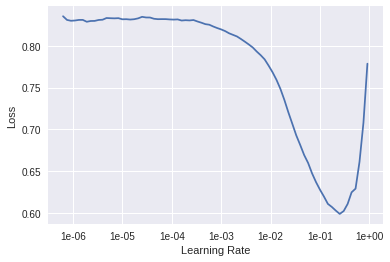

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [0]:
## train the model

learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.131084,0.115919,0.937703,0.898217,03:07
1,0.115351,0.104474,0.949177,0.903778,03:04
2,0.104822,0.097861,0.953537,0.915677,03:00
3,0.100577,0.094116,0.954337,0.917705,02:59
4,0.096181,0.092591,0.952621,0.918495,02:57


In [0]:
learn.save('stage-1')

In [0]:
## train all the layers

learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


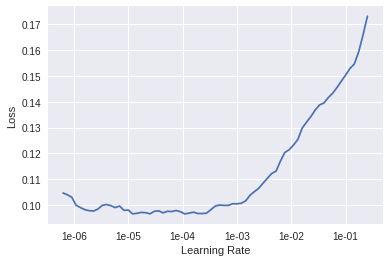

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098221,0.096896,0.952999,0.915470,03:10
1,0.099349,0.093650,0.953741,0.917268,03:12
2,0.092917,0.091020,0.956582,0.920690,03:07
3,0.090357,0.087003,0.956000,0.925172,03:08
4,0.081913,0.086505,0.956160,0.924936,03:11


In [0]:
learn.save('stage-2')

In [0]:
## increasing size to get more accuracy

data = (src.transform(tfms, size=256).databunch().normalize(imagenet_stats))
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


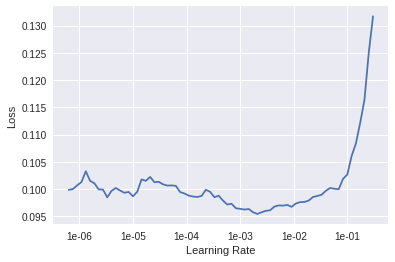

In [0]:
learn.recorder.plot()

In [0]:
lr = 1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.092331,0.086878,0.954889,0.923232,06:40
1,0.088502,0.085593,0.955579,0.924554,06:38
2,0.086625,0.086060,0.957548,0.922563,06:41
3,0.084155,0.083158,0.958442,0.927201,06:40
4,0.083310,0.082782,0.958384,0.927567,06:40


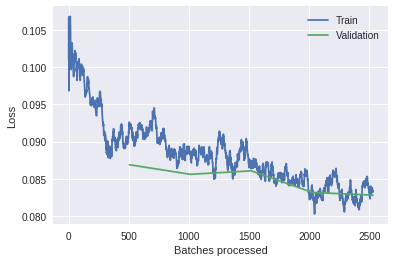

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2')

In [0]:
learn.export()

## testing with test data and submitting

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

100% 602M/603M [00:16<00:00, 37.6MB/s]
100% 603M/603M [00:16<00:00, 38.9MB/s]
 99% 301M/304M [00:06<00:00, 59.3MB/s]
100% 304M/304M [00:06<00:00, 46.5MB/s]


In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['clear primary',
 'agriculture clear habitation primary road',
 'agriculture clear primary water',
 'clear primary',
 'clear primary road water']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

## submit to kaggle

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100% 2.20M/2.20M [00:04<00:00, 494kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space